In [1]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pickle
from copy import deepcopy

from data_preprocessing import get_all_data
from utils import f1, accuracy, split_data

RUNS_PATH = "/home/jan/Desktop/Dev/epfl/cs_433/ml-first-project/data_clean/runs"


In [2]:
def load_results(file_subpath):
    with open(os.path.join(RUNS_PATH, file_subpath), "rb") as f:
        return pickle.load(f)

In [3]:
### load results
results = load_results("2024-10-26_13-20-28/All_columns__Logistic_Regression__results.pkl")
logreg = results["Logistic Regression"]

results = load_results("2024-10-26_13-20-28/Selected_columns_+_All_columns_PCA_var_>_0.8__Logistic_Regression__results.pkl")
svm = results["SVM"]

In [260]:
r = load_results("2024-10-27_21-41-09/All_columns__Ensemble__results.pkl")
ens = r["Ensemble"]

In [262]:
ens["all_val_scores"]

[0.42943144404133243, 0.42412759406710643, 0.4326656747990132]

## Plotting scores

In [4]:
def get_2d_hps_grid(hps, val_scores, get_hp_to_plot_1, get_hp_to_plot_2):
    uniq_1 = np.unique([get_hp_to_plot_1(hp) for hp in hps])
    uniq_2 = np.unique([get_hp_to_plot_2(hp) for hp in hps])
    grid_sum = np.zeros((len(uniq_1), len(uniq_2)))
    grid_seen_n = np.zeros((len(uniq_1), len(uniq_2)))
    for i, (hp, score) in enumerate(zip(hps, val_scores)):
        grid_sum[
            np.where(uniq_1 == get_hp_to_plot_1(hp))[0][0],
            np.where(uniq_2 == get_hp_to_plot_2(hp))[0][0]
        ] += score
        grid_seen_n[
            np.where(uniq_1 == get_hp_to_plot_1(hp))[0][0],
            np.where(uniq_2 == get_hp_to_plot_2(hp))[0][0]
        ] += 1
    assert np.all(grid_seen_n > 0)
    grid = grid_sum / grid_seen_n
    return grid, uniq_1, uniq_2

In [5]:
### prepare logreg results
hps = logreg["hyperparam_search_list"]
val_scores = logreg["all_val_scores"]
logreg_get_hp_to_plot_1 = lambda hps_dict: hps_dict["class_weights"][1]
logreg_get_hp_to_plot_2 = lambda hps_dict: hps_dict["reg_mul"]
logreg["grid"], logreg["uniq_1"], logreg["uniq_2"] = get_2d_hps_grid(hps, val_scores, logreg_get_hp_to_plot_1, logreg_get_hp_to_plot_2)

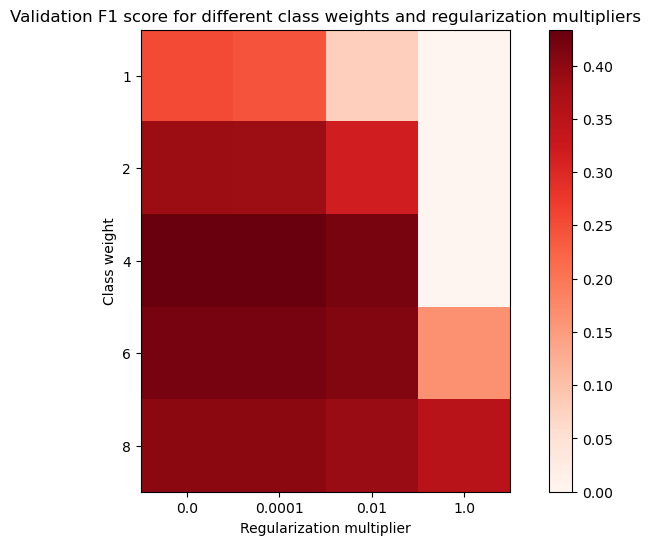

In [64]:
### plot heatmap of the validation scores wrt combination of two hyperparameters
plt.figure(figsize=(10, 6))
plt.imshow(logreg["grid"], cmap="Reds")
plt.colorbar()
plt.xlabel("Regularization multiplier")
plt.ylabel("Class weight")
plt.xticks(range(len(logreg["uniq_2"])), logreg["uniq_2"])
plt.yticks(range(len(logreg["uniq_1"])), logreg["uniq_1"])
plt.title("Validation F1 score for different class weights and regularization multipliers")
plt.show()

In [6]:
### prepare svm results
hps = svm["hyperparam_search_list"]
val_scores = svm["all_val_scores"]
svm_get_hp_to_plot_1 = lambda hps_dict: hps_dict["class_weights"][1]
svm_get_hp_to_plot_2 = lambda hps_dict: hps_dict["_lambda"]
svm["grid"], svm["uniq_1"], svm["uniq_2"] = get_2d_hps_grid(hps, val_scores, svm_get_hp_to_plot_1, svm_get_hp_to_plot_2)

/tmp/ipykernel_604828/1156275396.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.87, 1])  # Add space on the right for colorbar


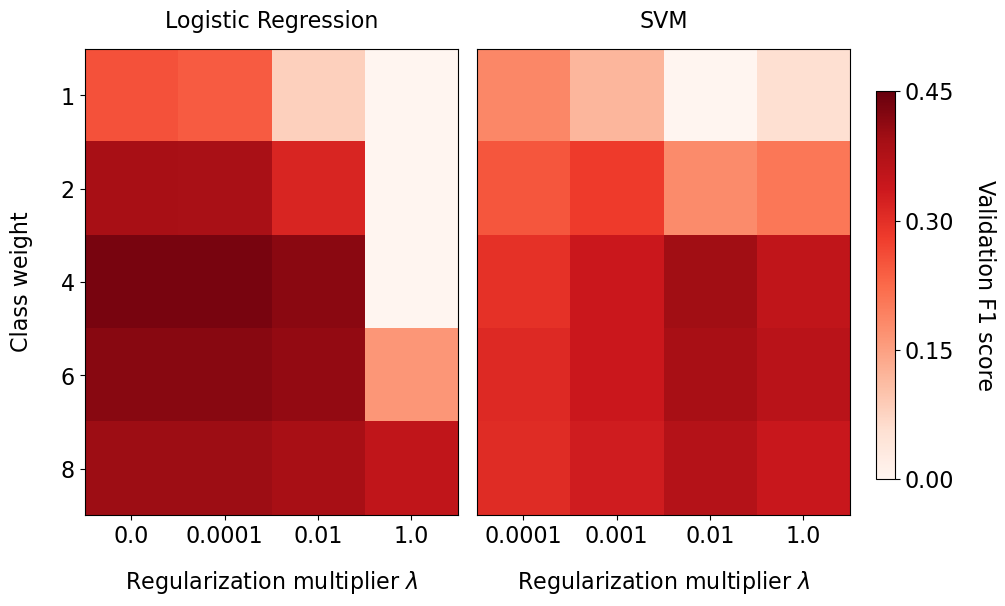

In [7]:
import matplotlib.ticker as ticker

fontsize = 16

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
im = axs[0].imshow(logreg["grid"], cmap="Reds", vmin=0, vmax=0.45)
axs[0].set_title("Logistic Regression", fontsize=fontsize, pad=15)
axs[0].set_xlabel(r"Regularization multiplier $\lambda$", fontsize=fontsize, labelpad=15)
axs[0].set_ylabel("Class weight", fontsize=fontsize, labelpad=20)
axs[0].set_xticks(range(len(logreg["uniq_2"])))
axs[0].set_xticklabels(logreg["uniq_2"], fontsize=fontsize)
axs[0].set_yticks(range(len(logreg["uniq_1"])))
axs[0].set_yticklabels(logreg["uniq_1"], fontsize=fontsize)
# remove spines

axs[1].imshow(svm["grid"], cmap="Reds", vmin=0, vmax=0.45)
axs[1].set_title("SVM", fontsize=fontsize, pad=15)
axs[1].set_xlabel(r"Regularization multiplier $\lambda$", fontsize=fontsize, labelpad=15)
axs[1].set_xticks(range(len(svm["uniq_2"])))
axs[1].set_xticklabels(svm["uniq_2"], fontsize=fontsize)

# no y-ticks for the second plot
axs[1].set_yticks([])
axs[1].set_yticklabels([])

# colorbar
cbar = fig.colorbar(im, ax=axs, fraction=0.025, pad=0.4)  # Increased pad to avoid overlap
cbar.ax.tick_params(labelsize=fontsize)
cbar.locator = ticker.MaxNLocator(nbins=3)
cbar.set_label("Validation F1 score", fontsize=fontsize, labelpad=30, rotation=270)

fig.tight_layout(rect=[0, 0, 0.87, 1])  # Add space on the right for colorbar
fig.subplots_adjust(wspace=0.05)
plt.show()

### save as pdf
fig.savefig("hyperparam_search.pdf", bbox_inches="tight")

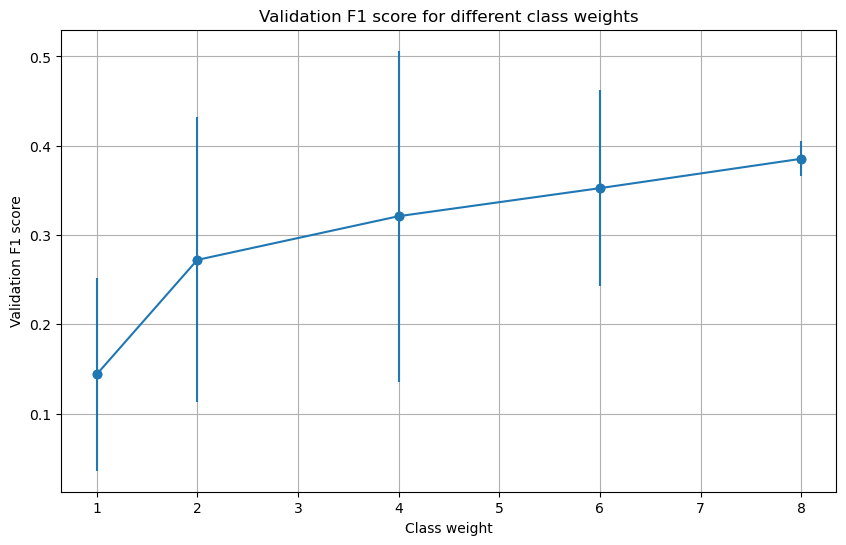

In [6]:
### plot only one of the hyperparameters
hp_avg_scores = grid.mean(axis=1)
hp_std_scores = grid.std(axis=1)
assert len(hp_avg_scores) == len(uniq_1) == len(hp_std_scores)
plt.figure(figsize=(10, 6))
plt.plot(uniq_1, hp_avg_scores, marker="o", color="tab:blue")
plt.errorbar(uniq_1, hp_avg_scores, yerr=hp_std_scores, fmt="o", color="tab:blue")

# plt.plot(uniq_1, hp_avg_scores, marker="o")
# plt.fill_between(uniq_1, hp_avg_scores - hp_std_scores, hp_avg_scores + hp_std_scores, alpha=0.2)

plt.xlabel("Class weight")
plt.ylabel("Validation F1 score")
plt.title("Validation F1 score for different class weights")
plt.grid()
plt.show()

## Training analysis

In [8]:
cfg = {
    "raw_data_path": "data_raw",
    "clean_data_path": "data_clean",
    "allow_load_clean_data": False,
    "remap_labels_to_01": True,
    "seed": 0,
}

In [9]:
### get data
x, x_final, y, ids, ids_final, col_idx_map, cleaned_col_idx_map = get_all_data(
    cfg=cfg,
    process_cols="all",
    pca_kwargs=None,
    verbose=False,
)
x_train, x_test, y_train, y_test = split_data(x=x, y=y, split_frac=0.2, seed=cfg["seed"])
sample_weights_train = np.array([logreg["hyperparams"]["class_weights"][yi] for yi in y_train])
sample_weights_test = np.array([logreg["hyperparams"]["class_weights"][yi] for yi in y_test])
print(f"x_train.shape: {x_train.shape}, x_test.shape: {x_test.shape}, y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}")

/home/jan/Desktop/Dev/epfl/cs_433/ml-first-project/data_preprocessing.py:240: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(arr)
/home/jan/miniconda3/envs/epfl/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


x_train.shape: (262508, 940), x_test.shape: (65627, 940), y_train.shape: (262508,), y_test.shape: (65627,)


In [177]:
### setup param update callback
history = defaultdict(list)
def update_callback(w, x, y, epoch, model, **kwargs):
    reg_mul_before = model.reg_mul
    model.reg_mul = 0

    ### Loss
    history["train_loss"].append(model.log_reg_loss(x=x_train, y=y_train, w=w, sample_weights=sample_weights_train))
    history["test_loss"].append(model.log_reg_loss(x=x_test, y=y_test, w=w, sample_weights=sample_weights_test))

    ### F1
    y_hat = model.predict(x=x_train, w=w)
    history["train_f1"].append(f1(y_train, y_hat))
    y_hat = model.predict(x=x_test, w=w)
    history["test_f1"].append(f1(y_test, y_hat))
    
    history["w"].append(deepcopy(w))
    history["epoch"].append(epoch)

    model.reg_mul = reg_mul_before

In [228]:
new_hps = deepcopy(logreg["hyperparams"])
new_hps["optim_algo"] = "gd"
new_hps["optim_kwargs"] = {'epochs': 150}
# new_hps["optim_algo"] = "sgd"
# new_hps["optim_kwargs"] = {'epochs': 3, "batch_size": 256}
# new_hps["use_line_search"] = False
# new_hps["gamma"] = 1e-2
new_hps

{'gamma': None,
 'use_line_search': True,
 'optim_algo': 'gd',
 'optim_kwargs': {'epochs': 150},
 'class_weights': {0: 1, 1: 4},
 'reg_mul': 0.0001,
 'verbose': False}

In [229]:
### train
history = defaultdict(list)
model = logreg["model_cls"](update_callback=update_callback, **new_hps)
model = model.fit(x_train, y_train)

In [230]:
# history_lbfgs = deepcopy(history)
history_gd = deepcopy(history)
# history_sgd = deepcopy(history)

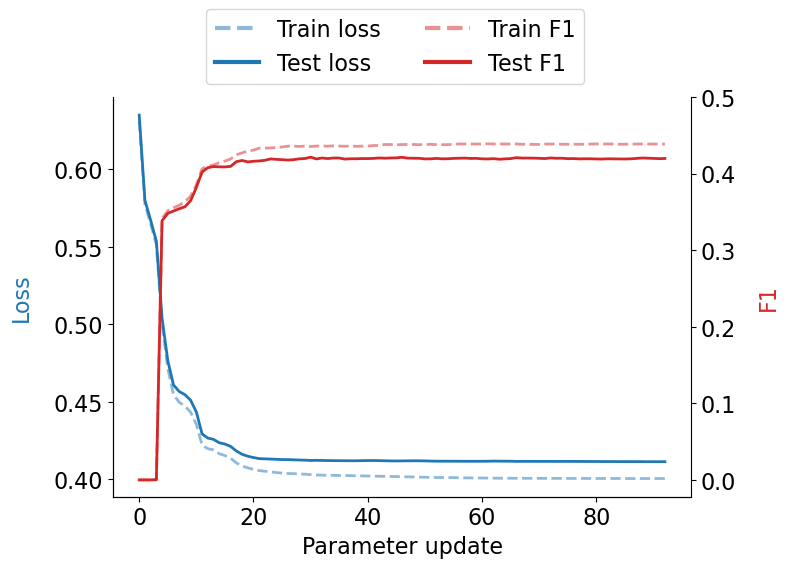

In [182]:
### plot
fontsize = 16
linewidth = 2

fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax1.plot(history["train_loss"], color="tab:blue", linestyle="--", label="Train loss", alpha=0.5, linewidth=linewidth)
ax1.plot(history["test_loss"], color="tab:blue", label="Test loss", linewidth=linewidth)
ax2.plot(history["train_f1"], color="tab:red", linestyle="--", label="Train F1", alpha=0.5, linewidth=linewidth)
ax2.plot(history["test_f1"], color="tab:red", label="Test F1", linewidth=linewidth)
ax1.set_xlabel("Parameter update", fontsize=fontsize)
ax1.set_ylabel("Loss", color="tab:blue", fontsize=fontsize, labelpad=15)
ax2.set_ylabel("F1", color="tab:red", fontsize=fontsize, labelpad=15)

### make legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc=0, fontsize=fontsize)
### add it above the plot
leg = fig.legend(lines + lines2, labels + labels2, loc="upper center",
    fontsize=fontsize, ncol=2, bbox_to_anchor=(0.5, 1.15))
# make the lines in the legend thicker
for line in leg.get_lines():
    line.set_linewidth(3.0)

### remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)

### ticks
ax1.set_yticks([.4,.45,.5,.55,.6])
ax2.set_yticks([0, .1, .2,.3,.4,.5])
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
### add grid
# ax1.grid(True, linestyle='--', alpha=0.5)
# ax2.grid(True, linestyle='--', alpha=0.5)

fig.tight_layout()
plt.show()

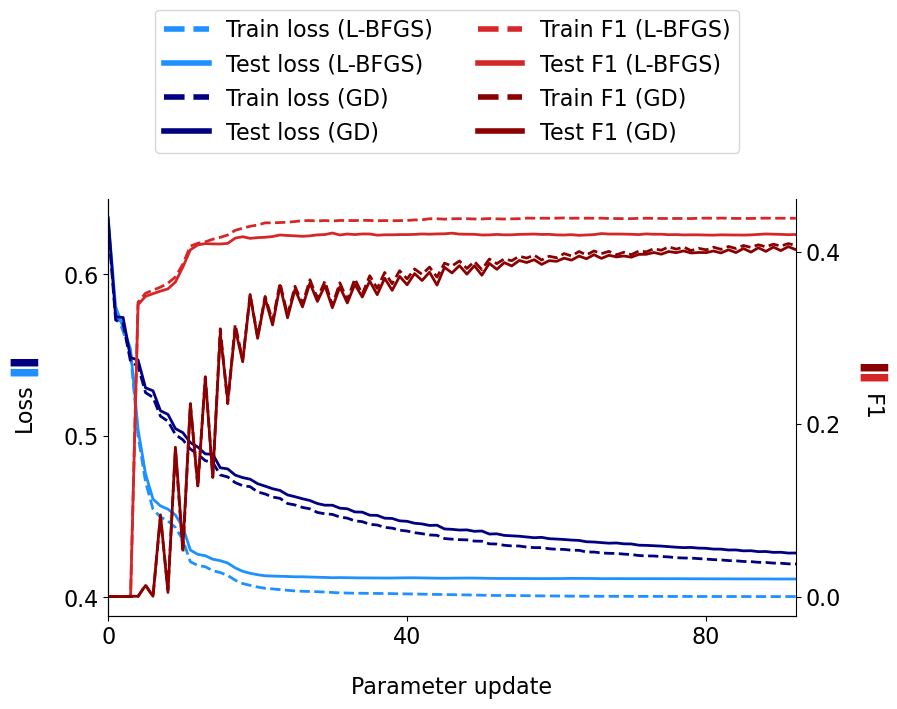

In [231]:
### plot
fontsize = 16
linewidth = 2

fig, ax1 = plt.subplots(figsize=(9, 5.3))
ax1.plot(history_lbfgs["train_loss"], color="dodgerblue", linestyle="--", label="Train loss (L-BFGS)", linewidth=linewidth)
ax1.plot(history_lbfgs["test_loss"], color="dodgerblue", label="Test loss (L-BFGS)", linewidth=linewidth)
ax1.plot(history_gd["train_loss"], color="navy", linestyle="--", label="Train loss (GD)", linewidth=linewidth)
ax1.plot(history_gd["test_loss"], color="navy", label="Test loss (GD)", linewidth=linewidth)
ax1.set_xlabel("Parameter update", fontsize=fontsize, labelpad=20)
ax1.set_ylabel("Loss", fontsize=fontsize, labelpad=20)

ax2 = ax1.twinx()
ax2.plot(history_lbfgs["train_f1"], color="tab:red", linestyle="--", label="Train F1 (L-BFGS)", linewidth=linewidth)
ax2.plot(history_lbfgs["test_f1"], color="tab:red", label="Test F1 (L-BFGS)", linewidth=linewidth)
ax2.plot(history_gd["train_f1"], color="darkred", linestyle="--", label="Train F1 (GD)", linewidth=linewidth)
ax2.plot(history_gd["test_f1"], color="darkred", label="Test F1 (GD)", linewidth=linewidth)
ax2.set_ylabel("F1", fontsize=fontsize, labelpad=30, rotation=270)



### make legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
leg = fig.legend(lines + lines2, labels + labels2, loc="upper center", fontsize=fontsize, ncol=2, bbox_to_anchor=(0.5, 1.35))
for line in leg.get_lines():
    line.set_linewidth(4.0)

### remove top and right spines
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

### ticks
ax1.set_yticks([.4, .5, .6])
ax1.tick_params(axis="both", which="major", labelsize=fontsize)
ax1.set_xlim(0, min(len(history_lbfgs["train_loss"]), len(history_gd["train_loss"])) - 1)

ax2.set_yticks([0, .2, .4])
ax2.tick_params(axis="both", which="major", labelsize=fontsize)
ax2.set_xlim(0, min(len(history_lbfgs["train_loss"]), len(history_gd["train_loss"])) - 1)

ax1.set_xticks([0, 40, 80])

### add grid
# ax1.grid(True, linestyle='--', alpha=0.5)
# ax2.grid(True, linestyle='--', alpha=0.5)
fig.text(0.014, 0.64, "━", color="dodgerblue", fontsize=fontsize*2, va="center")
fig.text(0.014, 0.66, "━", color="navy", fontsize=fontsize*2, va="center")
fig.text(0.959, 0.63, "━", color="tab:red", fontsize=fontsize*2, va="center")
fig.text(0.959, 0.65, "━", color="darkred", fontsize=fontsize*2, va="center")

fig.tight_layout()
plt.show()

### save as pdf
fig.savefig("optim_algo_comparison.pdf", bbox_inches="tight")

In [257]:
ws = np.array(history_lbfgs["w"])
ws_gd = np.array(history_gd["w"])
pca_inp = ws[:-1] - ws[-1]
pca_inp_gd = ws_gd[:len(ws)-1] - ws_gd[len(ws)-1]

# from models import PCA
# pca = PCA(n_components=2).fit(pca_inp)
# projs = pca.transform(pca_inp)

### use scikit-learn PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pca = make_pipeline(StandardScaler(), PCA(n_components=2))
pca.fit(pca_inp_gd)
projs = pca.transform(pca_inp)
projs_gd = pca.transform(pca_inp_gd)

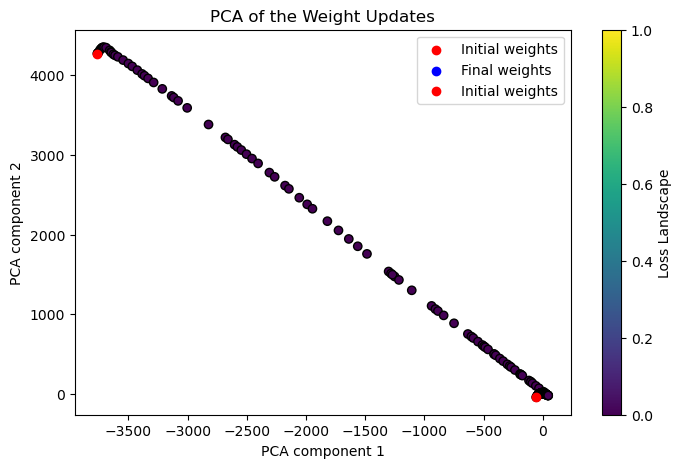

In [258]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Generate a finer grid for the loss landscape
n = 30
x = np.linspace(-45, 30, n)
y = np.linspace(-20, 20, n)
X, Y = np.meshgrid(x, y)

# Transform the grid points to the original weight space
# W_proj = np.c_[X.ravel(), Y.ravel()]
# W = pca.inverse_transform(W_proj)

# Calculate loss values for the contour plot with fixed regularization
# Z = np.zeros((n, n))
# model_orig_reg_mul = model.reg_mul
# model.reg_mul = 0
# for i in range(n):
#     for j in range(n):
#         w = W[i * n + j]
#         Z[i, j] = model.log_reg_loss(x=x_train, y=y_train, w=w, sample_weights=sample_weights_train)
# model.reg_mul = model_orig_reg_mul

# Plot the filled contour of the loss landscape
plt.pcolormesh(X, Y, Z, shading="auto", cmap="viridis")

# Scatter plot of the trajectory in PCA space
plt.scatter(projs[:, 0], projs[:, 1], c=history_lbfgs["epoch"][:len(projs)], cmap="viridis", edgecolor="k")
plt.scatter(projs[0, 0], projs[0, 1], c="red", label="Initial weights")
plt.scatter(projs[-1, 0], projs[-1, 1], c="blue", label="Final weights")

plt.scatter(projs_gd[:len(projs), 0], projs_gd[:len(projs), 1], c=history_lbfgs["epoch"][:len(projs)], cmap="viridis", edgecolor="k")
plt.scatter(projs_gd[0, 0], projs_gd[0, 1], c="red", label="Initial weights")

# Additional plot settings
plt.colorbar(label="Loss Landscape")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.title("PCA of the Weight Updates")
plt.legend()
plt.show()


In [167]:
with open("history_sgd.pkl", "wb") as f:
    pickle.dump(history_sgd, f)

In [139]:
# y_hat = results["Logistic Regression"]["model"].predict(x)
y_hat = model.predict(x)

In [140]:
f1(y, y_hat), accuracy(y, y_hat)

(0.4347356045351964, 0.8725250278086764)

In [145]:
w = model.w

### get the most important features
top_k = 10
top_k_idx = np.argsort(np.abs(w))[::-1][:top_k]
top_k_idx, w[top_k_idx]

(array([627, 211, 224,  65, 629, 787, 108, 184, 634, 130]),
 array([-1.9354948 , -0.9729472 , -0.83615655,  0.56680239, -0.54497953,
         0.54407225, -0.53855877, -0.52161365, -0.48224557, -0.47055876]))